# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [99]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [113]:
# Data transformations

# In this section, we create some helper functions that can help transform the data
# This includes cleaning the data. 
# Applying these functions results in better visualisations and insights into the data
# These functions can also be easily called for preprocessing before passing training data into model

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv(TRAINING_DATA_FILEPATH)

print(df.columns)

categorical_features = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id']
numerical_features = ['age_midpoint', 'number_inpatient', 'number_emergency', 'time_in_hospital']


def clean_inpatient_data():
    global df

    cols = ["number_inpatient", "number_outpatient", "number_emergency"]

    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

    # Replace NaN with 0 (patients often have no prior visits)
    df[cols] = df[cols].fillna(0)

    # Clip extreme outliers (very rare >10 visits)
    df[cols] = df[cols].clip(0, 10)

    df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

    df[cols + ["total_visits"]]

def clean_patient_interaction_cols():
    global df 

    encounter_cols = [
        "time_in_hospital",
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id"
    ]

    # Convert to numeric
    df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

    # Replace any NaN with a special category (rare)
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
        df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

    # Ensure time_in_hospital has no NaN
    df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())


def handle_categorical_features():
    return

def standard_cleaning():
    #dropping na/invalid values

    global df
    df = df[df['age_midpoint'].notna()]
    df = df[df['race'] != '?']
    df = df[df['gender'] != 'Unknown/Invalid']
    return

def get_age_mid(row):
    row = row[1:-1]
    start, end = list(map(int, row.split("-")))
    return (start + end) / 2

def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ]
    )

df["age_midpoint"] = df["age"].apply(get_age_mid)


clean_inpatient_data()

clean_patient_interaction_cols()

standard_cleaning()

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [114]:
# In the following sections we plot graphs that can visualise this cleaned data to get some insights into what fields are important for model building

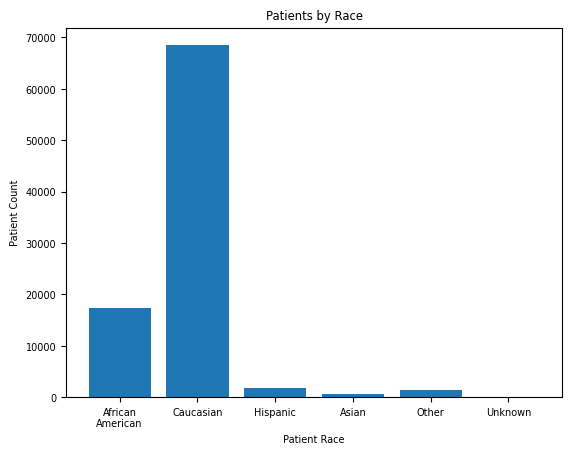

In [115]:
# Grouping by race to get some insights into frequency of patients by race

from matplotlib import pyplot as plt

african_americans = df[df['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = df[df['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = df[df['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = df[df['race'] == 'Asian']
asian_patients = len(asians)

others = df[df['race'] == 'Other']
other_race_patients = len(others)

unknowns = df[df['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()

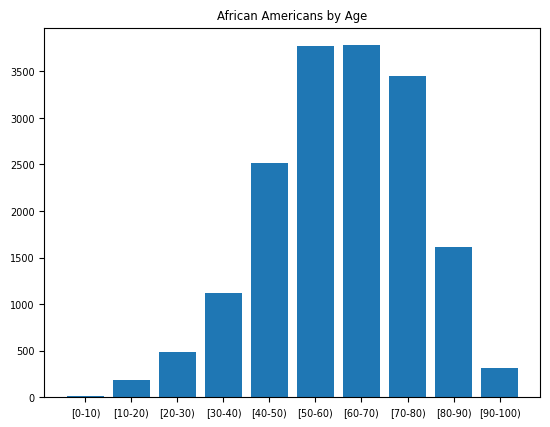

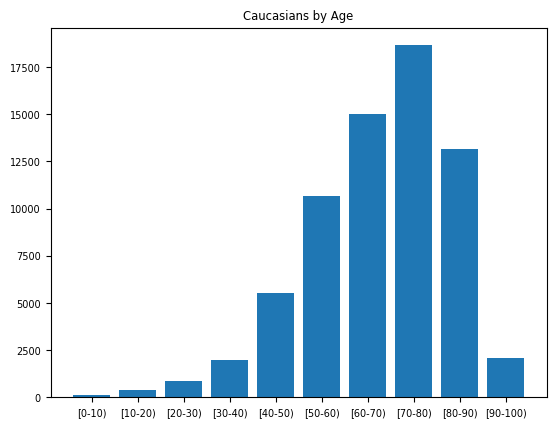

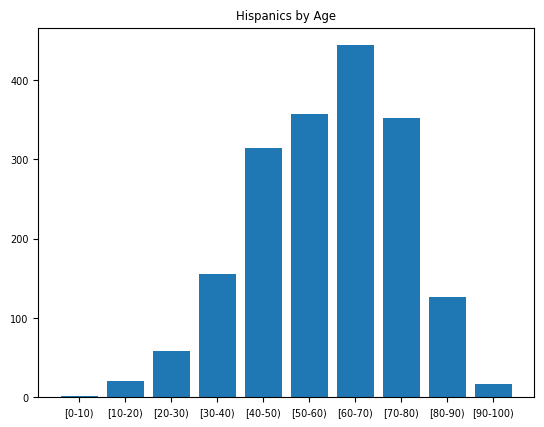

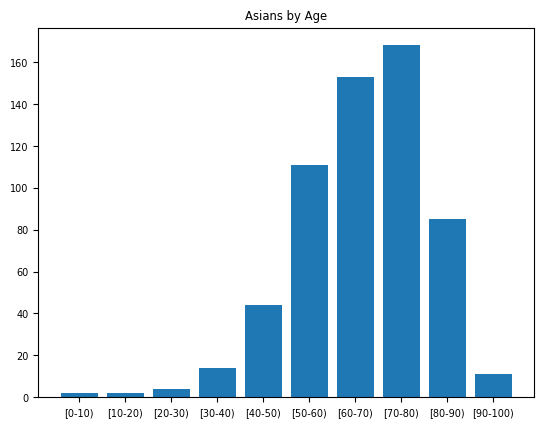

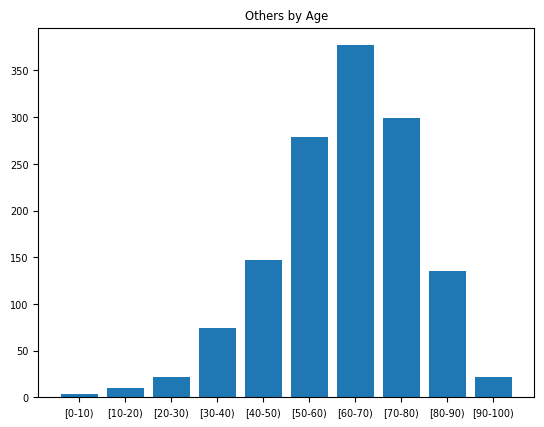

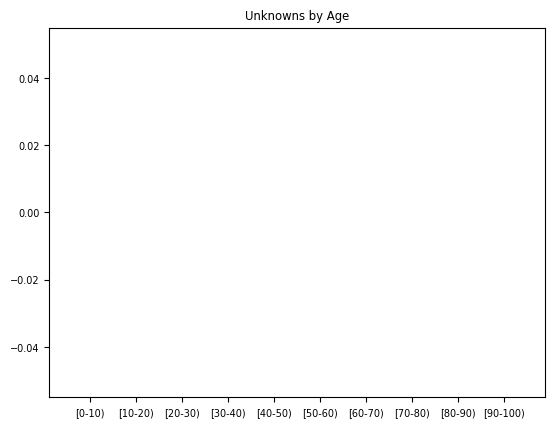

In [116]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()

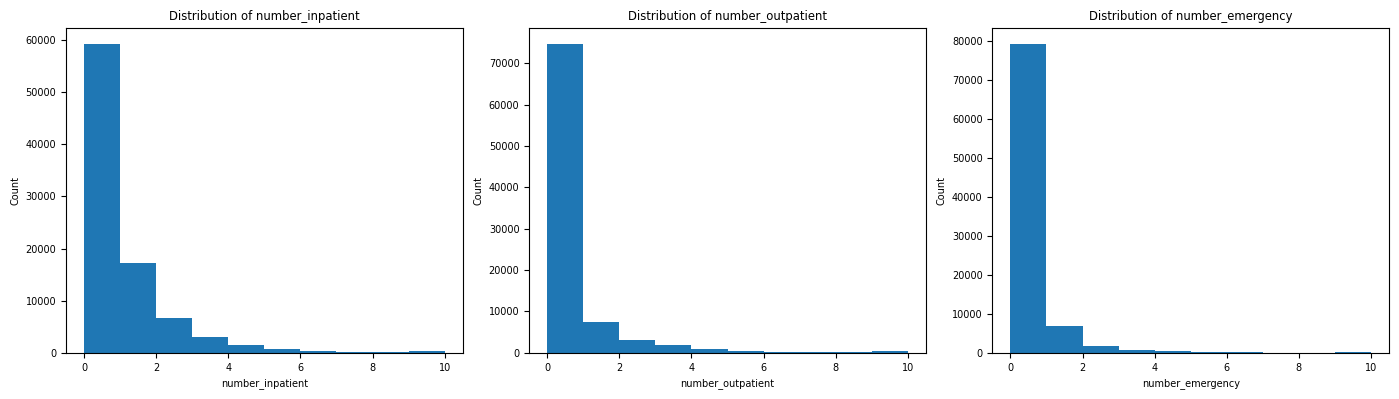

In [117]:

# understanding frequency and grouping of number_inpatient, number_outpatient and number_emergency

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

/var/folders/2_/cs6k5z6129j71cv3p08t5vym0000gn/T/ipykernel_28926/2947367813.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


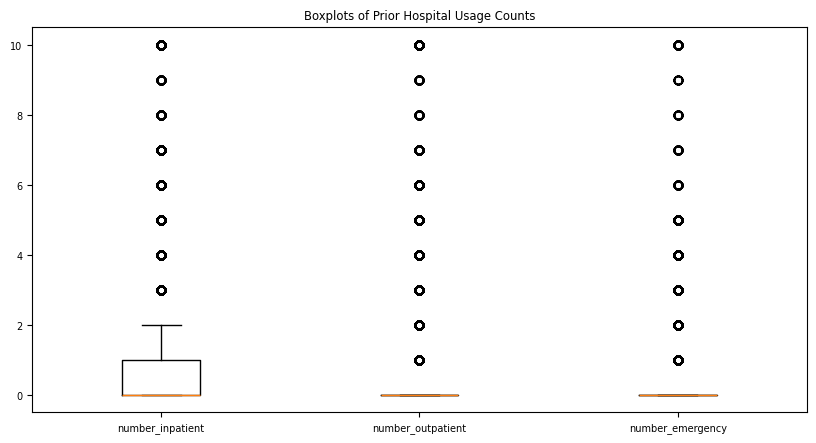

In [118]:
# understanding prior interaction with hospital after removing outliers
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()

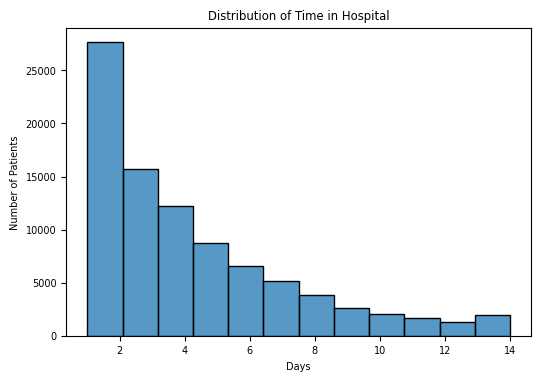

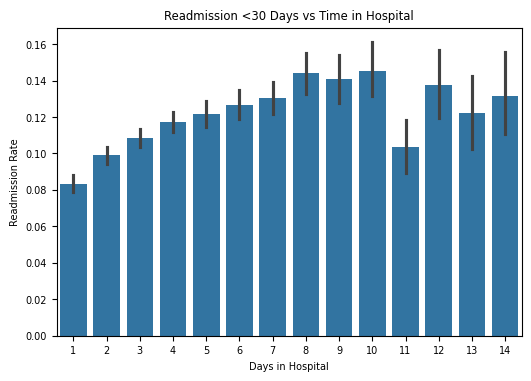

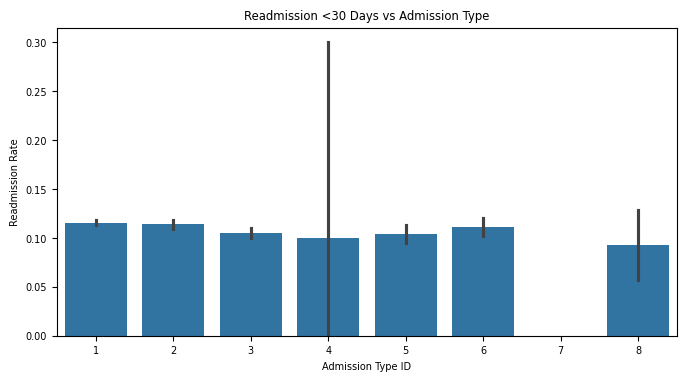

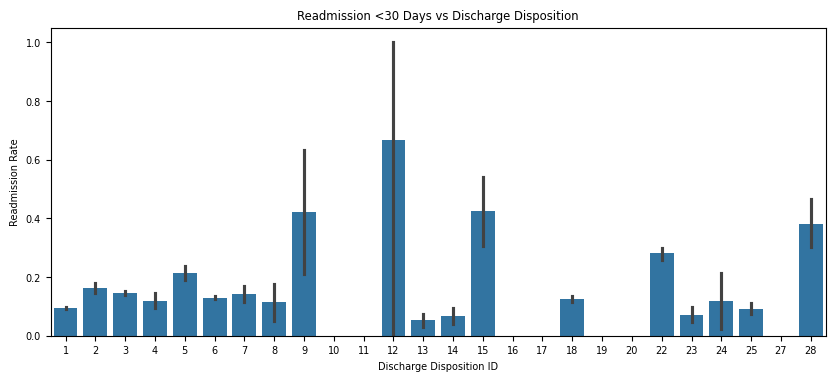

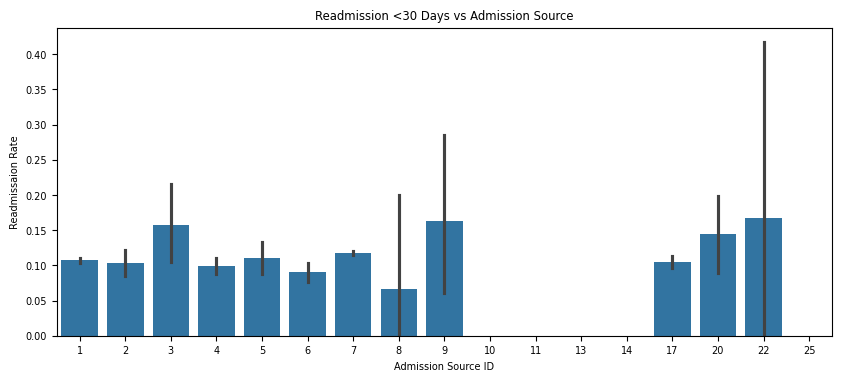

In [119]:
# plotting more fields regarding patient's prior interaction with hospital and their readmission rates
# this is to see which fields have some relationship to readmission

plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmissaion Rate")
plt.show()

# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [ ]:
# Binary classifier neural network

## Using: 'race','gender','age', 'admission_type_id','discharge_disposition_id'
##        'number_inpatient','number_emergency','time_in_hospital'

# Predicting: readmitted

import pandas as pd

cols = [
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital',
    'readmitted'
]
data = df[cols].copy()

# Race: drop unknown
data = data[data['race'] != '?']

# Gender: drop invalid
data = data[data['gender'] != 'Unknown/Invalid']

data["age_midpoint"].dropna()

# grouping readmittance into a binary (YES/NO) field
data['readmit_binary'] = (data['readmitted'] != 'NO').astype(int)

['Caucasian' 'AfricanAmerican' '?' 'Other' 'Hispanic' 'Asian']
['Female' 'Male' 'Unknown/Invalid']
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']


In [58]:

from sklearn.model_selection import train_test_split

X = data[[
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]]

y = data['readmit_binary']

# One-hot encode race, gender
X = pd.get_dummies(X, columns=['race','gender'], drop_first=True)

# Train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [59]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

numeric = [
    'age_midpoint','admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]

scaler = StandardScaler()
X_train_nn[numeric] = scaler.fit_transform(X_train_nn[numeric])
X_test_nn[numeric] = scaler.transform(X_test_nn[numeric])


binary_nn_model = Sequential([
    Dense(32, activation="relu", input_shape=(X_test_nn.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(4, activation="relu"),
    Dense(1, activation="sigmoid")
])

binary_nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = binary_nn_model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


/Users/varunsrinivasan/Documents/University/Year 3/Data Mining & Analysis/BENG0095CW/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 533us/step - accuracy: 0.6090 - loss: 0.6580 - val_accuracy: 0.6162 - val_loss: 0.6544
Epoch 2/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.6175 - loss: 0.6522 - val_accuracy: 0.6229 - val_loss: 0.6502
Epoch 3/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.6201 - loss: 0.6495 - val_accuracy: 0.6218 - val_loss: 0.6488
Epoch 4/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6213 - loss: 0.6470 - val_accuracy: 0.6228 - val_loss: 0.6481
Epoch 5/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.6225 - loss: 0.6454 - val_accuracy: 0.6229 - val_loss: 0.6458
Epoch 6/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.6235 - loss: 0.6437 - val_accuracy: 0.6246 - val_loss: 0.6448
Epoch 7/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6239 - loss: 0.6427 - val_accuracy: 0.6259 - val_loss: 0.6439
Epoch 8/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.6244 - loss: 0.64

In [60]:
# 3 way logistic regression model

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

train_df = pd.read_csv(TRAINING_DATA_FILEPATH)
test_df = pd.read_csv(TEST_DATA_FILEPATH)

train_df = train_df.copy()

train_df = train_df[
    (train_df['race'] != '?') &
    (train_df['gender'] != 'Unknown/Invalid')
]


def get_age_mid(row):
    row = row[1:-1]
    start, end = list(map(int, row.split("-")))
    return (start + end) / 2

train_df['age_midpoint'] = train_df['age'].apply(get_age_mid)

features = [
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]

X_train_log_reg = train_df[features]
y_train_log_reg = train_df['readmitted']

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train_log_reg)

# data preprocessing
categorical_features = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id']
numerical_features = ['age_midpoint', 'number_inpatient', 'number_emergency', 'time_in_hospital']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


In [61]:
# fitting regression model to the training data
log_reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=1000
    ))
])

log_reg_model.fit(X_train_log_reg, y_train_enc)

y_pred_log_reg = log_reg_model.predict(X_train_log_reg)


# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [62]:
# inference of the binary neural network on the training dataset
from sklearn.metrics import accuracy_score, classification_report

# Predict probabilities on training data
y_train_prob = binary_nn_model.predict(X_train_nn)

# Convert probabilities to class labels (0/1)
y_train_pred = (y_train_prob > 0.5).astype("int32").ravel()

# Evaluation on training data
print("Training Accuracy:", accuracy_score(y_train_nn, y_train_pred))
print("Training Classification Report:")
print(classification_report(y_train_nn, y_train_pred))


2239/2239 ━━━━━━━━━━━━━━━━━━━━ 1s 221us/step
Training Accuracy: 0.6268377476508943
Training Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.69     38365
           1       0.65      0.44      0.52     33258

    accuracy                           0.63     71623
   macro avg       0.63      0.61      0.61     71623
weighted avg       0.63      0.63      0.61     71623



In [63]:
# inference of logistic regression model on the training data
print("Accuracy:", accuracy_score(y_train_enc, y_pred_log_reg))
print(classification_report(
    y_train_enc,
    y_pred_log_reg,
    target_names=label_encoder.classes_
))

Accuracy: 0.5725295714237845
              precision    recall  f1-score   support

         <30       0.41      0.02      0.04     10076
         >30       0.51      0.25      0.33     31496
          NO       0.59      0.90      0.71     47957

    accuracy                           0.57     89529
   macro avg       0.50      0.39      0.36     89529
weighted avg       0.54      0.57      0.50     89529



# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [64]:

# inference of the binary neural network model

y_pred = (binary_nn_model.predict(X_test_nn) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test_nn, y_pred))
print("\nClassification report:")
print(classification_report(y_test_nn, y_pred))

560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
Accuracy: 0.6296772031721211

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      9592
           1       0.65      0.44      0.52      8314

    accuracy                           0.63     17906
   macro avg       0.64      0.62      0.61     17906
weighted avg       0.63      0.63      0.62     17906



In [65]:

# inference of the 3-way logistic regression model
test_df = test_df.copy()

test_df["age_midpoint"] = test_df['age'].apply(get_age_mid)

test_df = test_df[
    (test_df['race'] != '?') &
    (test_df['gender'] != 'Unknown/Invalid')
]

X_test_log_reg = test_df[features]
y_test_log_reg = test_df['readmitted']

y_test_enc = label_encoder.transform(y_test_log_reg)

y_test_pred = log_reg_model.predict(X_test_log_reg)

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=label_encoder.classes_
))

Test Accuracy: 0.5754290876242095
              precision    recall  f1-score   support

         <30       0.42      0.02      0.05      1093
         >30       0.51      0.25      0.34      3511
          NO       0.59      0.90      0.71      5359

    accuracy                           0.58      9963
   macro avg       0.51      0.39      0.37      9963
weighted avg       0.54      0.58      0.51      9963

